In [1]:
import uproot
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import yahist
import itertools
import mplhep as hep

plt.rcParams.update({"figure.facecolor":  (1,1,1,0)})

from utils.analysis import Optimization

TAG = "kscans"

In [2]:
presort_babies = sorted(glob.glob(f"../analysis/studies/vbswh/output_{TAG}/Run2/*.root"))
presort_babies = [baby for baby in presort_babies if "data" not in baby]
presort_babies = [baby for baby in presort_babies if "Lambda" not in baby]
babies = []
for baby in sorted(presort_babies, reverse=True):
    if "EWK" in baby.split("/")[-1]:
        babies.append(baby)
    else:
        babies.insert(0, baby)
        
for baby_i, baby in enumerate(babies):
    if "VBSWH_SM" in baby.split("/")[-1] in baby:
        babies.append(babies.pop(baby_i))
        break
babies

['../analysis/studies/vbswh/output_kscans/Run2/Bosons.root',
 '../analysis/studies/vbswh/output_kscans/Run2/SingleTop.root',
 '../analysis/studies/vbswh/output_kscans/Run2/TTX.root',
 '../analysis/studies/vbswh/output_kscans/Run2/TTbar1L.root',
 '../analysis/studies/vbswh/output_kscans/Run2/TTbar2L.root',
 '../analysis/studies/vbswh/output_kscans/Run2/VBSWH_mkW.root',
 '../analysis/studies/vbswh/output_kscans/Run2/VH.root',
 '../analysis/studies/vbswh/output_kscans/Run2/WJets.root',
 '../analysis/studies/vbswh/output_kscans/Run2/EWKWLep.root',
 '../analysis/studies/vbswh/output_kscans/Run2/VBSWH_SM.root']

In [3]:
vbswh = Optimization(
    sig_root_files=[baby for baby in babies if "VBSWH_mkW" in baby],
    bkg_root_files=[baby for baby in babies if "VBSWH_mkW" not in baby and "VBSWH_SM" not in baby],
    ttree_name="tree",
    weight_columns=[
        "xsec_sf", "lep_id_sf", "ewkfix_sf", 
        "elec_reco_sf", "muon_iso_sf", 
        "btag_sf", "pu_sf", "prefire_sf", "trig_sf", "puid_sf"
    ],
#     plots_dir=f"/home/users/jguiang/public_html/vbswh_plots/{TAG}/opt",
    plots_dir="/home/users/jguiang/public_html/vbswh_plots/aps/opt",
    cms_label="Private work",
    sample_labels = {
#         "VBSWH_SM": "VBSWH (SM)", 
        "TTbar1L": r"$t\bar{t}+1\ell$",
        "TTbar2L": r"$t\bar{t}+2\ell$",
        "TTX": r"$t\bar{t}+X$",
        "SingleTop": "Single top",
        "WJets": "W+jets",
        "EWKWLep": r"EWK W$\rightarrow\ell\nu$"
    },
    reweight_column="reweights"
)
vbswh.df["presel_noVBS_noBVeto"] = vbswh.df.eval(
    "hbbjet_score > 0.3"
)
vbswh.df["presel_noVBS"] = vbswh.df.eval(
    "passes_bveto and hbbjet_score > 0.3"
)
vbswh.df["presel_noDetaJJ"] = vbswh.df.eval(
    "passes_bveto and M_jj > 500 and hbbjet_score > 0.3"
)
vbswh.df["presel"] = vbswh.df.eval(
    "passes_bveto and M_jj > 500 and abs(deta_jj) > 3 and hbbjet_score > 0.3"
)
# vbswh.df["SR"] = vbswh.df.eval(
#     "presel and ST > 1200 and M_jj > 1500 and abs(deta_jj) > 4 and hbbjet_score > 0.9 and hbbjet_msoftdrop < 150"
# )
vbswh.df["SR2"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 1500 and hbbjet_score > 0.9 and abs(deta_jj) > 4 and hbbjet_msoftdrop < 150"
)
vbswh.df["regionA"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) > 4 and hbbjet_msoftdrop >= 150"
)
vbswh.df["regionB"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) <= 4 and hbbjet_msoftdrop >= 150"
)
vbswh.df["regionC"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) <= 4 and hbbjet_msoftdrop < 150"
)
vbswh.df["SR1"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) > 4 and hbbjet_msoftdrop < 150"
)
# vbswh.make_selection("passes_bveto == True")
# vbswh.make_selection("passes_bveto != True")

Loading bkg babies: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:23<00:00, 10.38s/it]


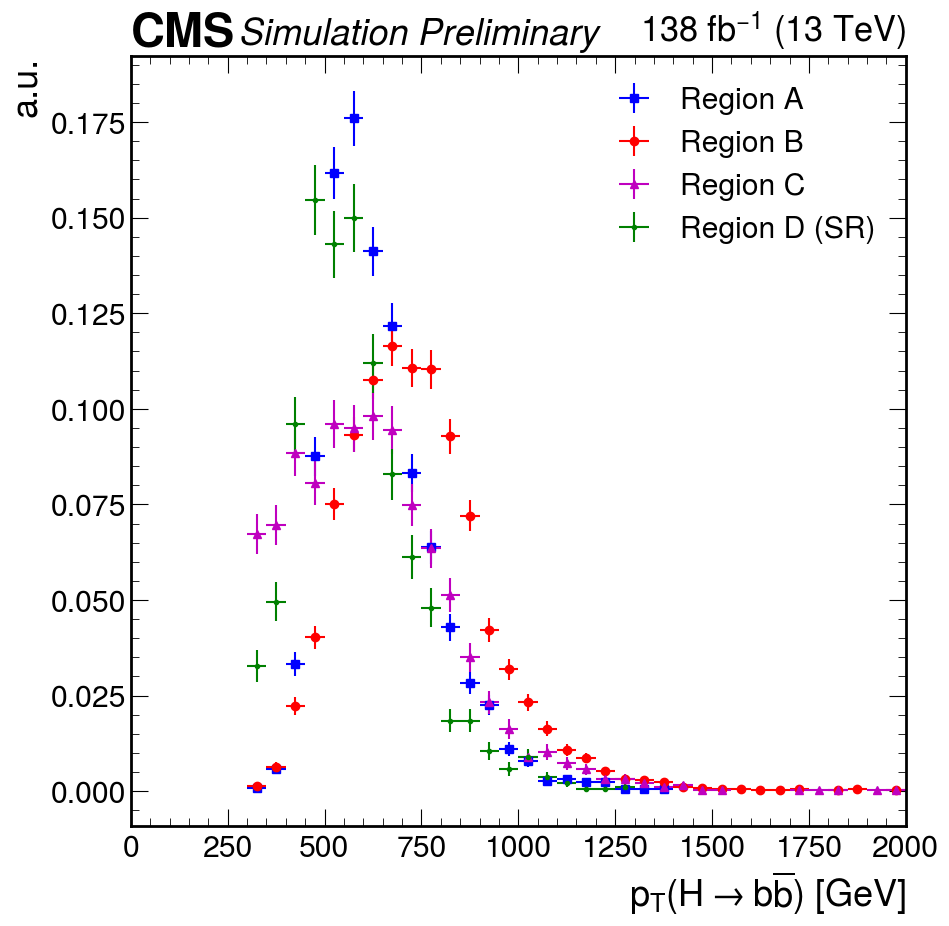

In [4]:
bins = np.linspace(0, 2000, 41)

fig, axes = plt.subplots()

ttbar_df = vbswh.bkg_df(selection="name == 'TTbar1L' or name == 'TTbar2L'")

regionA_hist = yahist.Hist1D(
    ttbar_df[ttbar_df.regionA].hbbjet_pt.values,
    bins=bins,
    color="b",
    label="Region A"
).normalize()
regionA_hist.plot(ax=axes, errors=True, fmt="s")

regionB_hist = yahist.Hist1D(
    ttbar_df[ttbar_df.regionB].hbbjet_pt.values,
    bins=bins,
    color="r",
    label="Region B"
).normalize()
regionB_hist.plot(ax=axes, errors=True, fmt="o")

regionC_hist = yahist.Hist1D(
    ttbar_df[ttbar_df.regionC].hbbjet_pt.values,
    bins=bins,
    color="m",
    label="Region C"
).normalize()
regionC_hist.plot(ax=axes, errors=True, fmt="^")

regionD_hist = yahist.Hist1D(
    ttbar_df[ttbar_df.SR1].hbbjet_pt.values,
    bins=bins,
    color="g",
    label="Region D (SR)"
).normalize()
regionD_hist.plot(ax=axes, errors=True, fmt=".")

hep.cms.label("Preliminary", data=False, lumi=138, loc=0, ax=axes)

axes.set_ylabel("a.u.");
axes.set_xlabel(r"$p_T(H\rightarrow b\overline{b})$ [GeV]");

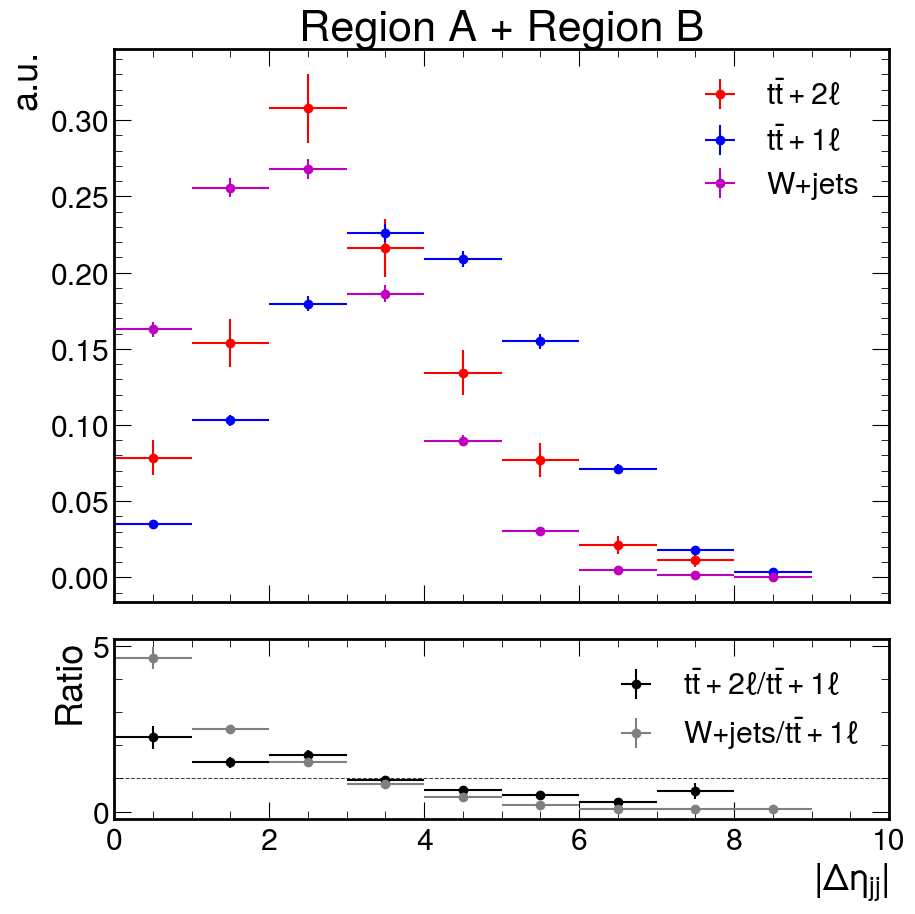

In [5]:
selection = "(regionA or regionB)"
bins = np.linspace(0, 10, 11)

fig = plt.figure()
gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.1)
hist_axes = fig.add_subplot(gs[0])
ratio_axes = fig.add_subplot(gs[1])


tt1l_df = vbswh.bkg_df(selection=f"{selection} and name == 'TTbar1L'")
tt2l_df = vbswh.bkg_df(selection=f"{selection} and name == 'TTbar2L'")
wjets_df = vbswh.bkg_df(selection=f"{selection} and name == 'WJets'")

tt1l_hist = yahist.Hist1D(
    np.abs(tt1l_df.deta_jj.values),
    bins=bins,
    color="b",
    label=r"$t\bar{t}+1\ell$"
).normalize()
tt2l_hist = yahist.Hist1D(
    np.abs(tt2l_df.deta_jj.values),
    bins=bins,
    color="r",
    label=r"$t\bar{t}+2\ell$"
).normalize()
wjets_hist = yahist.Hist1D(
    np.abs(wjets_df.deta_jj.values),
    bins=bins,
    color="m",
    label="W+jets"
).normalize()
ratio_hist = tt1l_hist/tt2l_hist

tt2l_hist.plot(ax=hist_axes, errors=True)
tt1l_hist.plot(ax=hist_axes, errors=True)
wjets_hist.plot(ax=hist_axes, errors=True)
(tt2l_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="k", label=r"$t\bar{t}+2\ell/t\bar{t}+1\ell$")
(wjets_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="grey", label=r"W+jets$/t\bar{t}+1\ell$")

hist_axes.set_xticklabels([]);
hist_axes.set_ylabel("a.u.")
hist_axes.set_title("Region A + Region B");

ratio_axes.axhline(y=1, color="k", linestyle="--", alpha=0.75, linewidth=0.75)
# ratio_axes.legend().remove()
ratio_axes.set_ylabel("Ratio");
ratio_axes.set_xlabel(r"$|\Delta\eta_{jj}|$");

plot_file = f"/home/users/jguiang/public_html/vbswh_plots/{TAG}/opt/AB_wjets_vs_ttbar.pdf"
plt.savefig(plot_file, bbox_inches="tight")

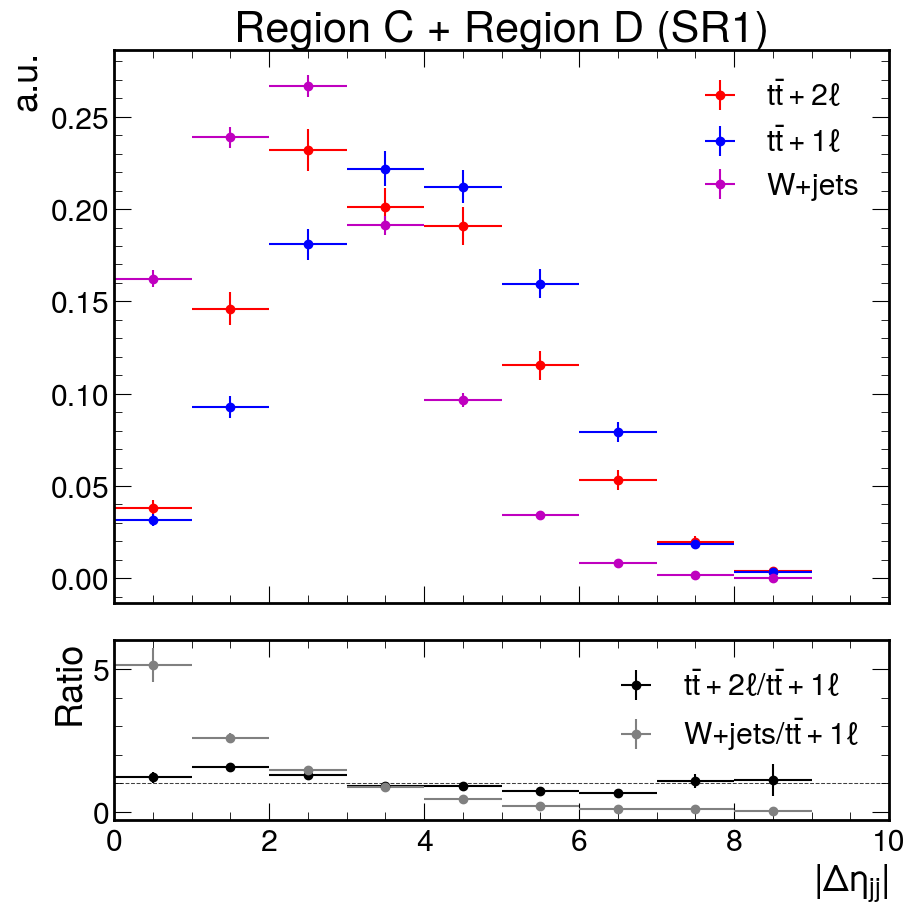

In [6]:
selection = "(regionC or SR1)"
bins = np.linspace(0, 10, 11)

fig = plt.figure()
gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.1)
hist_axes = fig.add_subplot(gs[0])
ratio_axes = fig.add_subplot(gs[1])


tt1l_df = vbswh.bkg_df(selection=f"{selection} and name == 'TTbar1L'")
tt2l_df = vbswh.bkg_df(selection=f"{selection} and name == 'TTbar2L'")
wjets_df = vbswh.bkg_df(selection=f"{selection} and name == 'WJets'")

tt1l_hist = yahist.Hist1D(
    np.abs(tt1l_df.deta_jj.values),
    bins=bins,
    color="b",
    label=r"$t\bar{t}+1\ell$"
).normalize()
tt2l_hist = yahist.Hist1D(
    np.abs(tt2l_df.deta_jj.values),
    bins=bins,
    color="r",
    label=r"$t\bar{t}+2\ell$"
).normalize()
wjets_hist = yahist.Hist1D(
    np.abs(wjets_df.deta_jj.values),
    bins=bins,
    color="m",
    label="W+jets"
).normalize()
ratio_hist = tt1l_hist/tt2l_hist

tt2l_hist.plot(ax=hist_axes, errors=True)
tt1l_hist.plot(ax=hist_axes, errors=True)
wjets_hist.plot(ax=hist_axes, errors=True)
(tt2l_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="k", label=r"$t\bar{t}+2\ell/t\bar{t}+1\ell$")
(wjets_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="grey", label=r"W+jets$/t\bar{t}+1\ell$")

hist_axes.set_xticklabels([]);
hist_axes.set_ylabel("a.u.")
hist_axes.set_title("Region C + Region D (SR1)");

ratio_axes.axhline(y=1, color="k", linestyle="--", alpha=0.75, linewidth=0.75)
# ratio_axes.legend().remove()
ratio_axes.set_ylabel("Ratio");
ratio_axes.set_xlabel(r"$|\Delta\eta_{jj}|$");

plot_file = f"/home/users/jguiang/public_html/vbswh_plots/{TAG}/opt/CD_wjets_vs_ttbar.pdf"
plt.savefig(plot_file, bbox_inches="tight")

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/aps/opt/hbbjet_msoftdrop_correlations_presel_noDetaJJ_and_M_jj_gt_600_and_ST_gt_900_and_hbbjet_score_gt_0p9.pdf


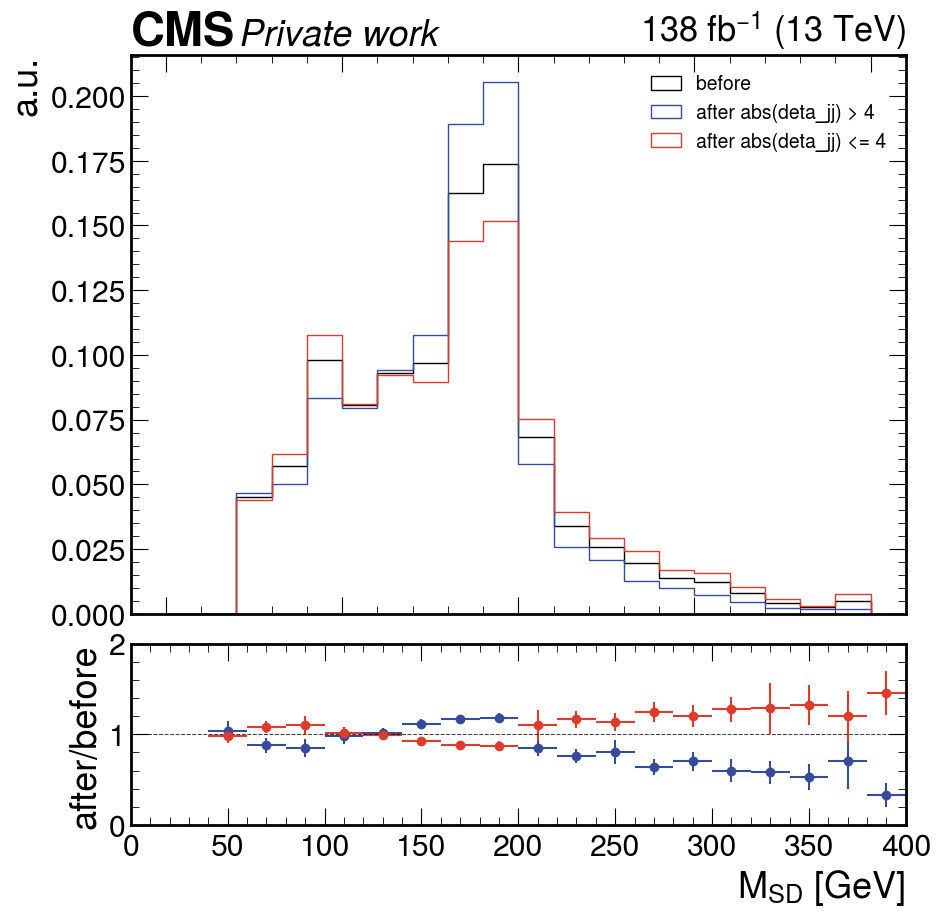

In [7]:
vbswh.plot_correlation(
    "hbbjet_msoftdrop", 
    np.linspace(0, 400, 21), 
    selections=[
        "abs(deta_jj) > 4",
        "abs(deta_jj) <= 4"
    ],
    base_selection="presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9",
    x_label="$M_{SD}$ [GeV]",
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/aps/opt/deta_jj_correlations_presel_noDetaJJ_and_M_jj_gt_600_and_ST_gt_900_and_hbbjet_score_gt_0p9.pdf


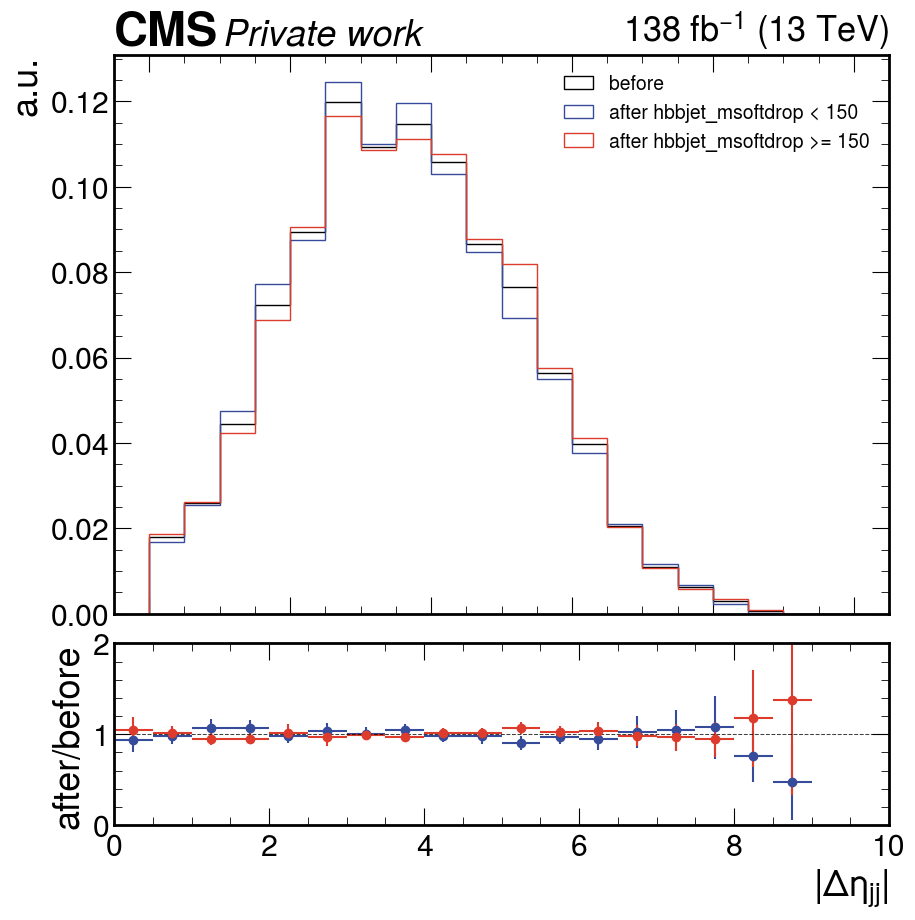

In [8]:
vbswh.plot_correlation(
    "deta_jj", 
    np.linspace(0, 10, 21),  
    selections=[
        "hbbjet_msoftdrop < 150",
        "hbbjet_msoftdrop >= 150"
    ], 
    base_selection="presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$"
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/aps/opt/deta_jj_correlations_presel_noDetaJJ_and_hbbjet_msoftdrop_geq_150.pdf


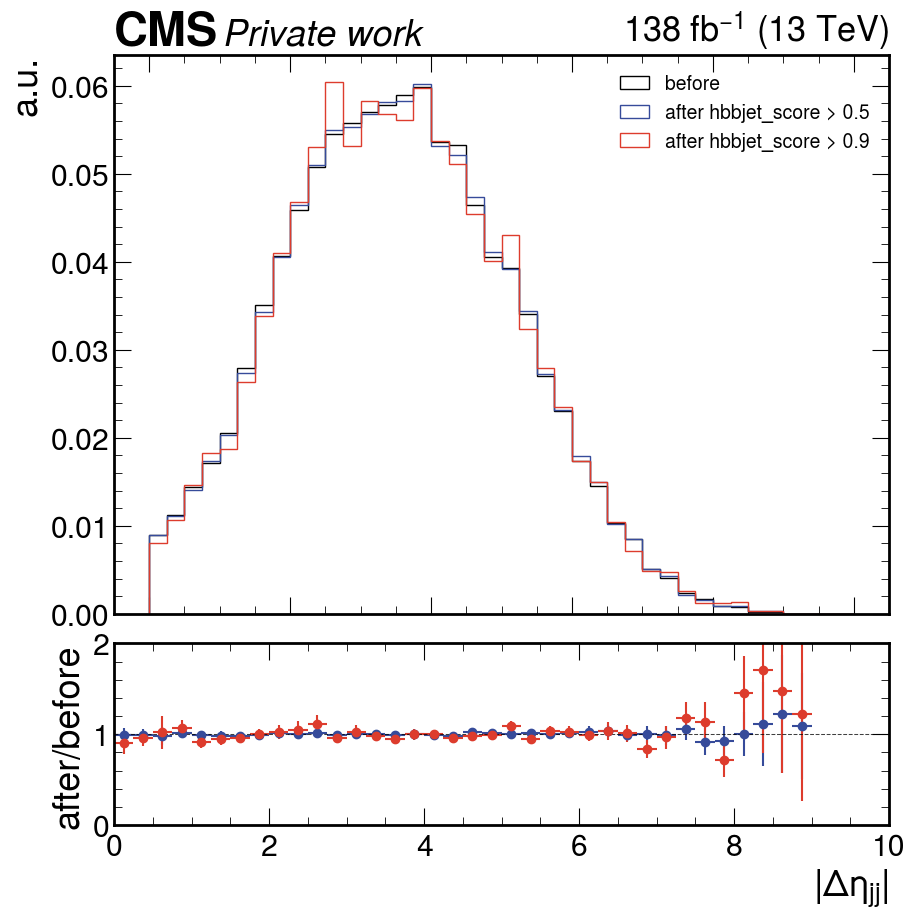

In [9]:
vbswh.plot_correlation(
    "deta_jj", 
    np.linspace(0, 10, 41),  
    selections=[
        "hbbjet_score > 0.5",
        "hbbjet_score > 0.9"
    ], 
    base_selection="presel_noDetaJJ and hbbjet_msoftdrop >= 150",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$"
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/aps/opt/deta_jj_correlations_presel_noDetaJJ_and_hbbjet_msoftdrop_geq_150.pdf


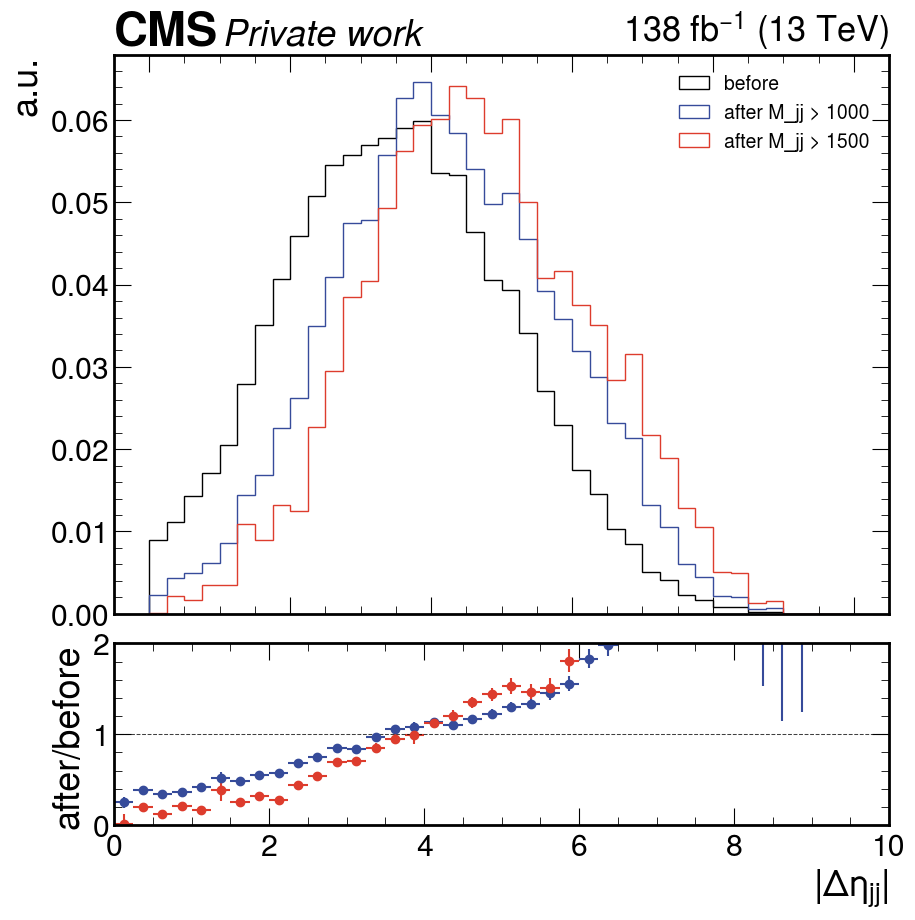

In [10]:
vbswh.plot_correlation(
    "deta_jj", 
    np.linspace(0, 10, 41),  
    selections=[
        "M_jj > 1000",
        "M_jj > 1500"
    ], 
    base_selection="presel_noDetaJJ and hbbjet_msoftdrop >= 150",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$"
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/aps/opt/hbbjet_msoftdrop_sig_vs_bkg_stacked_presel_and_hbbjet_score_lt_0p6.pdf


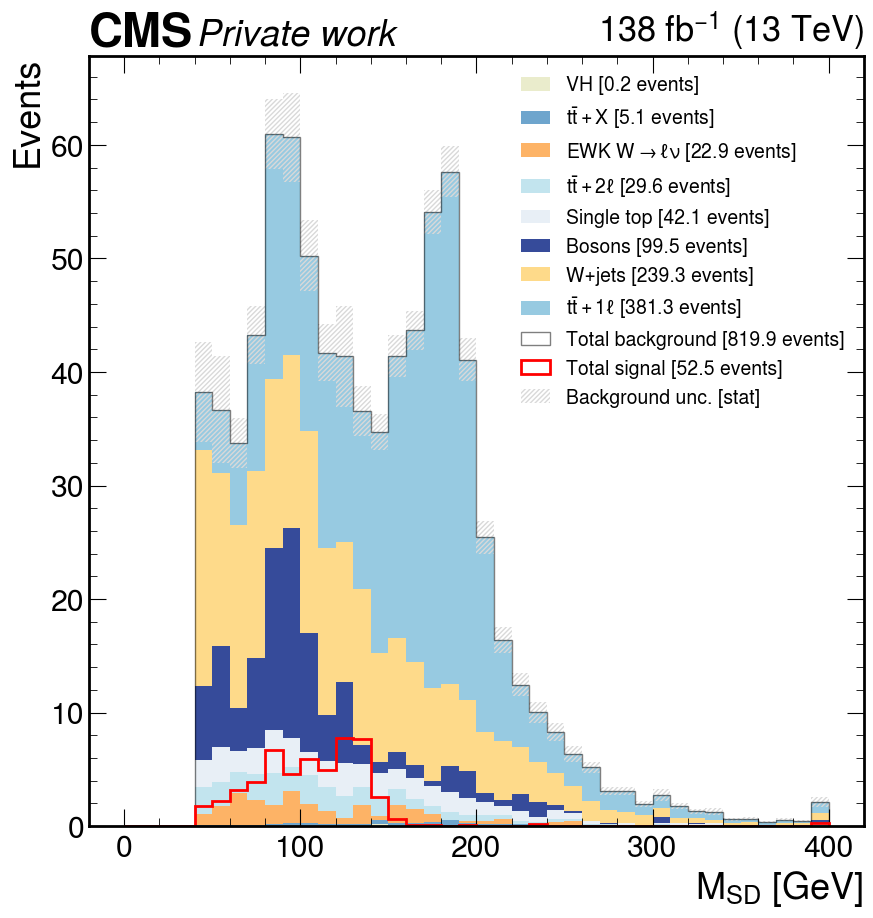

In [11]:
axes = vbswh.plot_sig_vs_bkg(
    "hbbjet_msoftdrop", np.linspace(0, 400, 41), 
    selection="presel and hbbjet_score < 0.6",
    x_label="$M_{SD}$ [GeV]",
    stacked=True,
#     norm=True
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/aps/opt/ST_correlations_presel.pdf


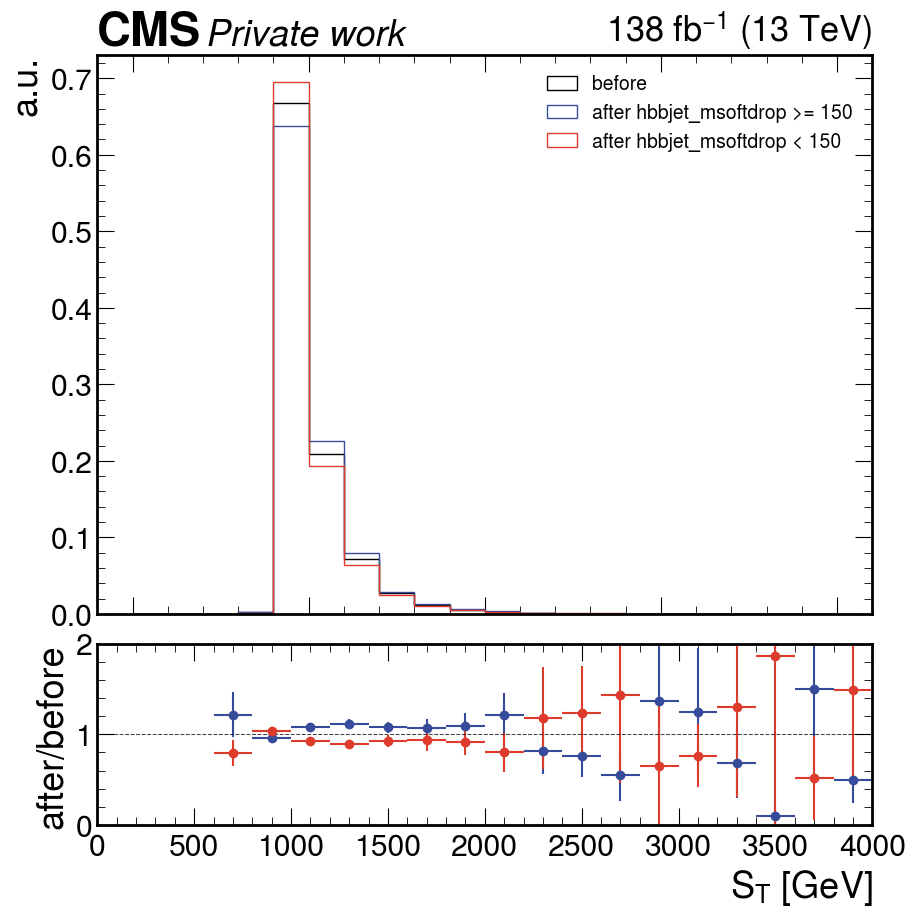

In [12]:
vbswh.plot_correlation(
    "ST", 
    np.linspace(0, 4000, 21),  
    selections=[
        "hbbjet_msoftdrop >= 150",
        "hbbjet_msoftdrop < 150"
    ], 
    base_selection="presel",
    x_label=r"$S_T$ [GeV]"
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/aps/opt/LT_sig_vs_bkg_stacked_logy_presel_noDetaJJ.pdf


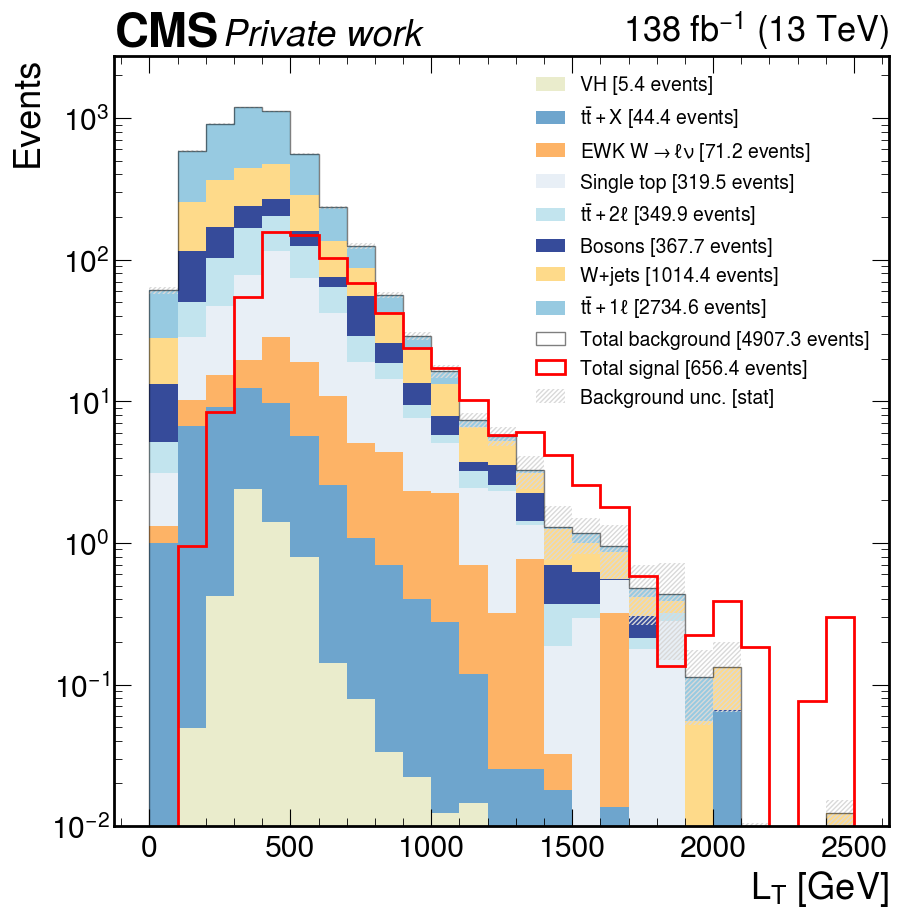

In [13]:
axes = vbswh.plot_sig_vs_bkg(
    "LT", np.linspace(0, 2500, 26), 
    selection="presel_noDetaJJ",
    x_label="$L_T$ [GeV]",
    stacked=True,
    logy=True
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/aps/opt/LT_sig_vs_bkg_stacked_presel_noDetaJJ.pdf


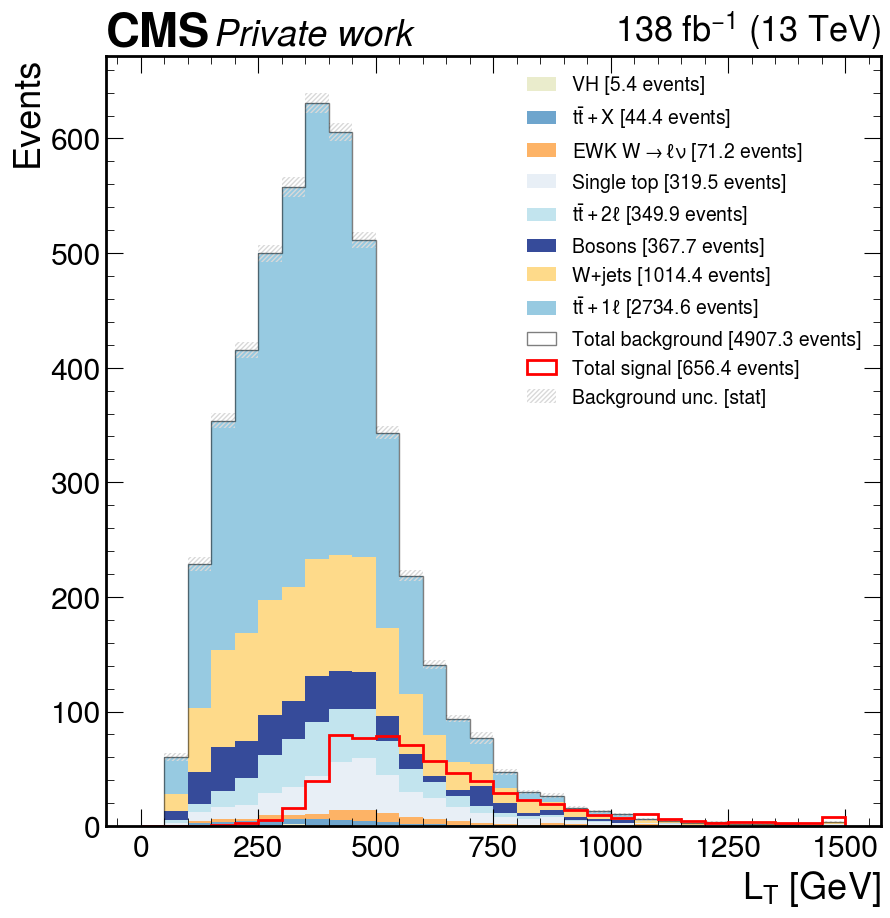

In [14]:
axes = vbswh.plot_sig_vs_bkg(
    "LT", np.linspace(0, 1500, 31), 
    selection="presel_noDetaJJ",
    x_label="$L_T$ [GeV]",
    stacked=True,
#     norm=True
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/aps/opt/ST_sig_vs_bkg_stacked_logy_presel_noDetaJJ.pdf


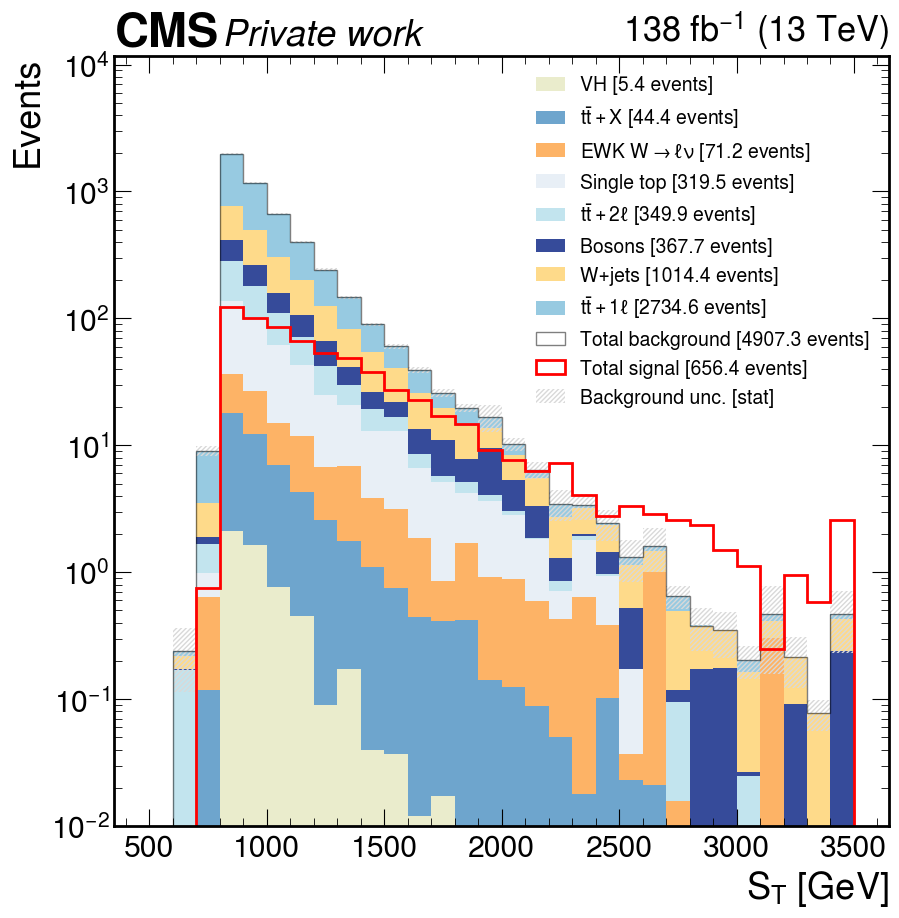

In [15]:
axes = vbswh.plot_sig_vs_bkg(
    "ST", np.linspace(500, 3500, 31), 
    selection="presel_noDetaJJ",
    x_label="$S_T$ [GeV]",
    stacked=True,
    logy=True
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/aps/opt/ST_sig_vs_bkg_stacked_presel.pdf


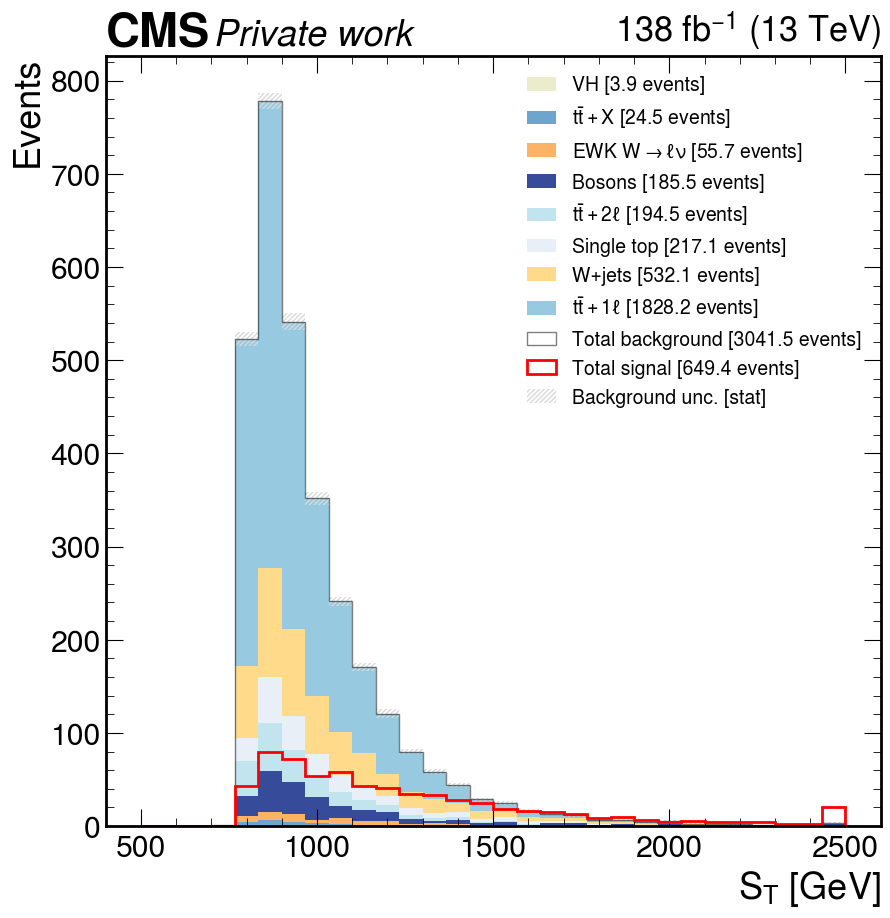

In [16]:
axes = vbswh.plot_sig_vs_bkg(
    "ST", np.linspace(500, 2500, 31), 
    selection="presel",
    x_label="$S_T$ [GeV]",
    stacked=True,
#     logy=True,
#     norm=True
);

In [17]:
vbswh.get_event_counts(selection="presel and hbbjet_msoftdrop >= 150")

(19.395293984899382, 1487.6994452943277)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/aps/opt/hbbjet_msoftdrop_sig_vs_bkg_stacked_presel_noDetaJJ.pdf


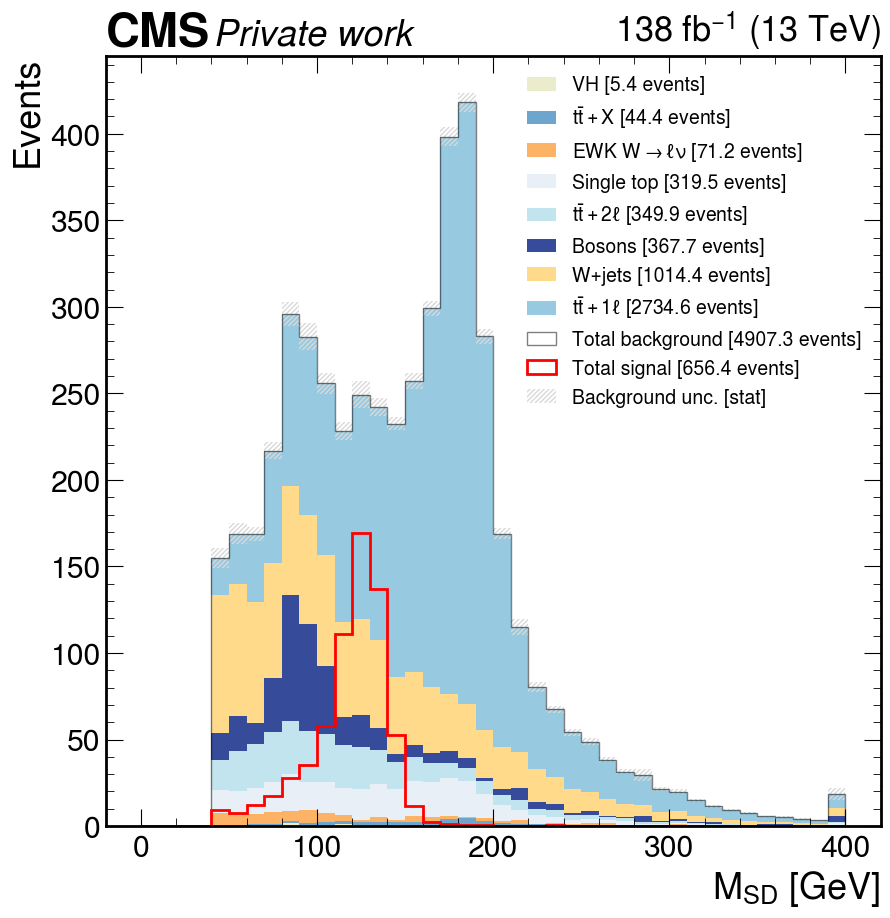

In [18]:
axes = vbswh.plot_sig_vs_bkg(
    "hbbjet_msoftdrop", np.linspace(0, 400, 41), 
    selection="presel_noDetaJJ",
    x_label="$M_{SD}$ [GeV]",
    stacked=True,
#     norm=True
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/aps/opt/hbbjet_score_sig_vs_bkg_stacked_presel_noDetaJJ.pdf


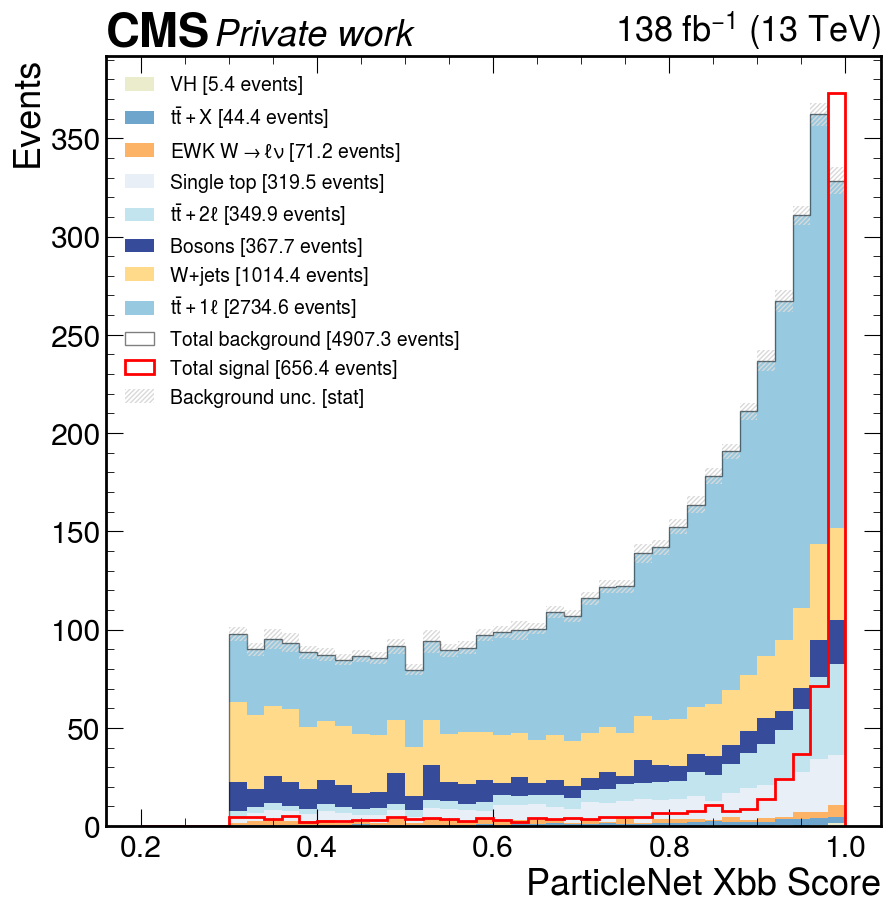

In [19]:
axes = vbswh.plot_sig_vs_bkg(
    "hbbjet_score", np.linspace(0.2, 1, 41), 
    selection="presel_noDetaJJ",
    x_label="ParticleNet Xbb Score",
    stacked=True,
    legend_loc="upper left"
#     norm=True
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/aps/opt/M_jj_sig_vs_bkg_stacked_logy_presel_noDetaJJ.pdf


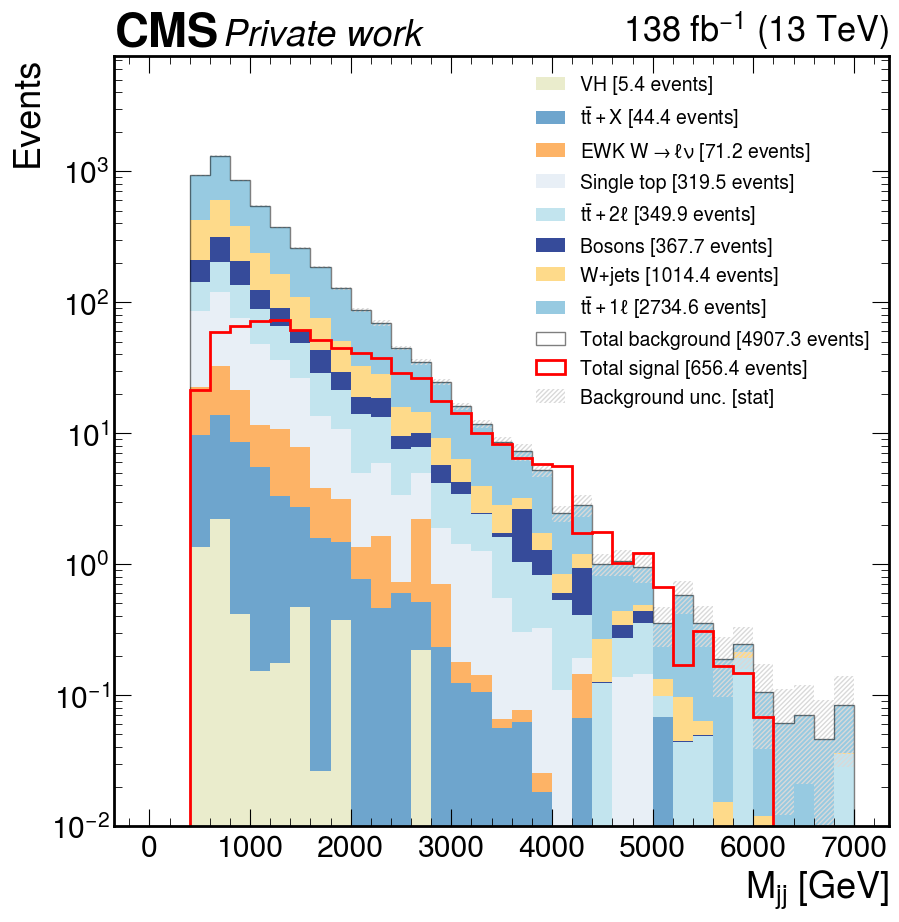

In [20]:
axes = vbswh.plot_sig_vs_bkg(
    "M_jj", np.linspace(0, 7000, 36), 
    selection="presel_noDetaJJ",
    x_label="$M_{jj}$ [GeV]",
    stacked=True,
    logy=True
);

In [21]:
vbswh.get_event_counts(selection="presel_noDetaJJ and abs(deta_jj) <= 3")

(6.957023106817163, 1865.7350741532803)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/aps/opt/deta_jj_sig_vs_bkg_stacked_presel_noDetaJJ.pdf


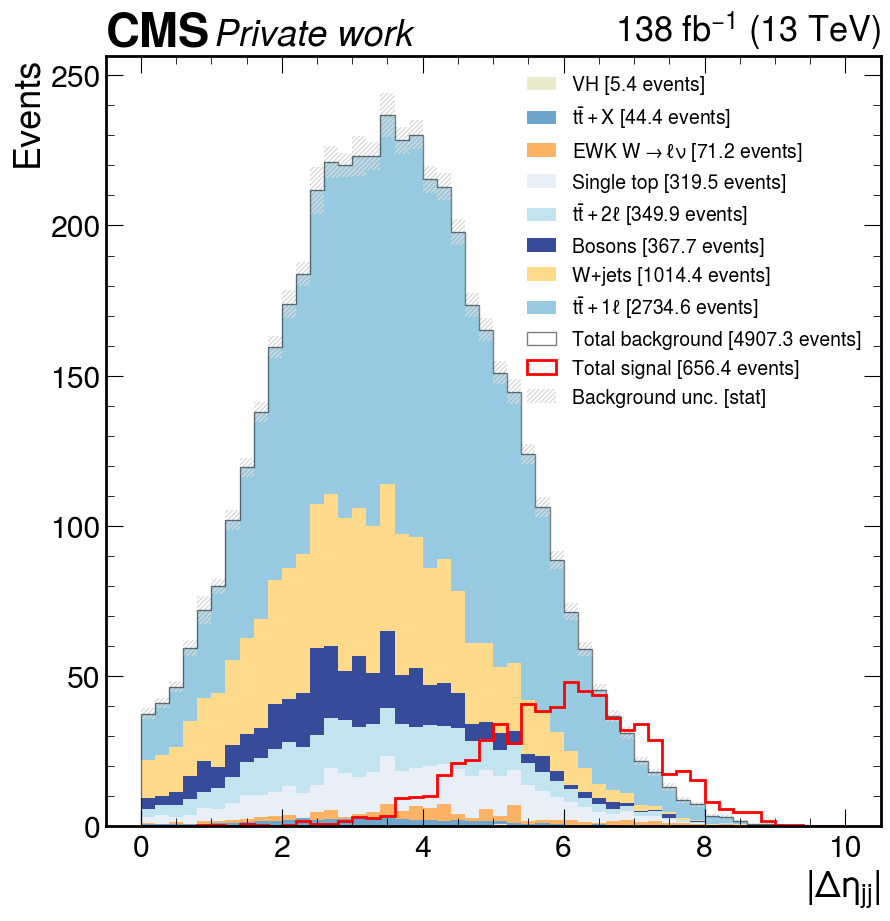

In [22]:
axes = vbswh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(0, 10, 51), 
    selection="presel_noDetaJJ", 
    x_label="$|\Delta\eta_{jj}|$",
    transf=abs,
    stacked=True
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/aps/opt/deta_jj_sig_vs_bkg_stacked_presel.pdf


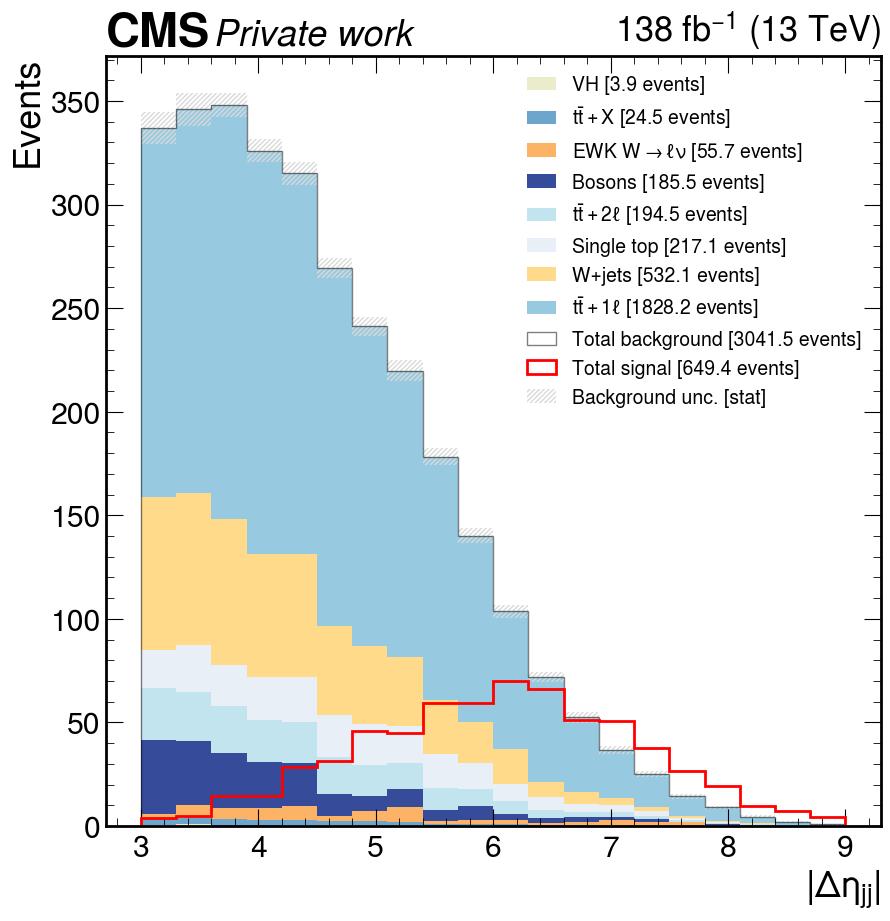

In [23]:
axes = vbswh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(3, 9, 21), 
    selection="presel", 
    x_label="$|\Delta\eta_{jj}|$",
    transf=abs,
    stacked=True
);

In [24]:
vbswh.fom_scan(
    "deta_jj", [3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7], operator=">", 
    base_selection="M_jj > 1500", abs=True
)

sel,sig,bkg,fom
M_jj > 1500,539.5552393007733,5122.292364222337,7.538826223707277
M_jj > 1500 and abs(deta_jj) > 3.5,537.7127449714767,3966.9532795478162,8.537324469168052
M_jj > 1500 and abs(deta_jj) > 4,533.5698002813057,3455.4624577514946,9.076912550697983
M_jj > 1500 and abs(deta_jj) > 4.5,526.8144241848471,2855.7313885098188,9.858230761475236
M_jj > 1500 and abs(deta_jj) > 5,506.16179925772275,2192.8279857666507,10.809038970625238
M_jj > 1500 and abs(deta_jj) > 5.5,474.58809606542076,1586.8722895500482,11.913677852613077
M_jj > 1500 and abs(deta_jj) > 6,411.28663413620075,1092.9612620473629,12.44062534868224
M_jj > 1500 and abs(deta_jj) > 6.5,308.21081991654285,720.7364469028284,11.480469221173589
M_jj > 1500 and abs(deta_jj) > 7,206.8743454828077,424.7398637521659,10.037952248814477


Wrote plot to /home/users/jguiang/public_html/vbswh_plots/aps/opt/LT_sig_vs_bkg_stacked_M_jj_gt_1500_and_abs(deta_jj)_gt_5.pdf


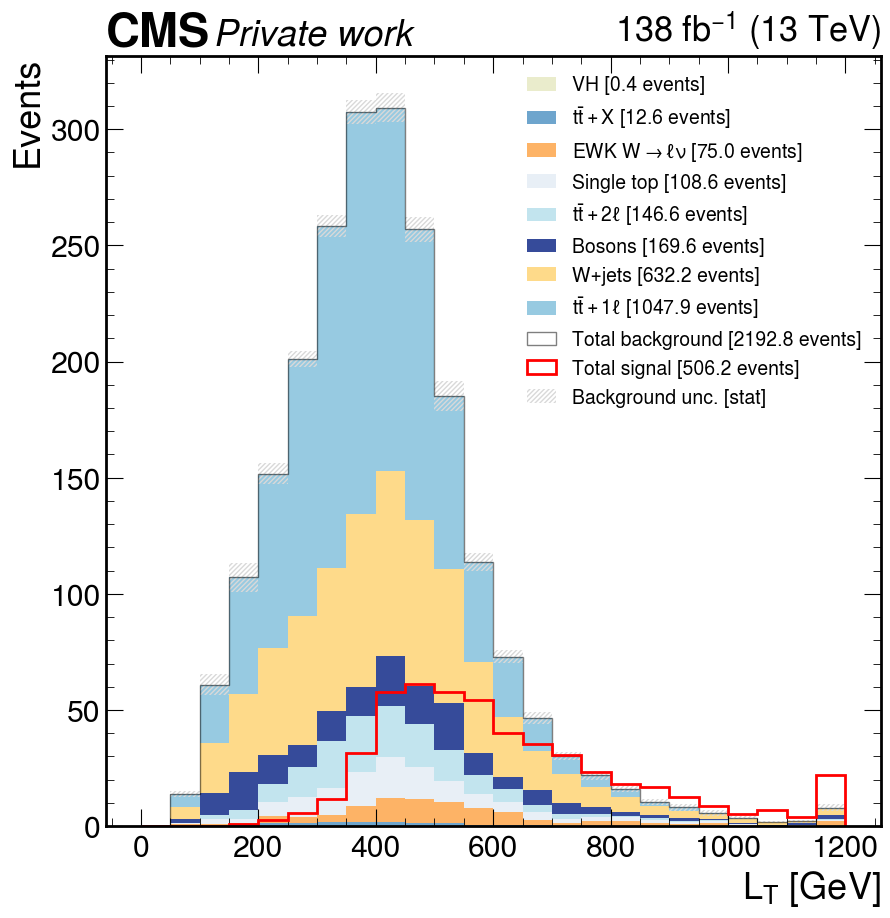

In [25]:
vbswh.plot_sig_vs_bkg(
    "LT", np.linspace(0, 1200, 25), 
    selection="M_jj > 1500 and abs(deta_jj) > 5", 
    x_label="$L_T$ [GeV]",
    stacked=True
);

In [26]:
vbswh.fom_scan(
    "LT", [500, 600, 700, 800, 900, 1000, 1100, 1200], operator=">", 
    base_selection="M_jj > 1500 and abs(deta_jj) > 5"
);

sel,sig,bkg,fom
M_jj > 1500 and abs(deta_jj) > 5,506.16179925772275,2192.8279857666507,10.809038970625238
M_jj > 1500 and abs(deta_jj) > 5 and LT > 500,335.4274152796826,526.2259725535437,14.622189768253284
M_jj > 1500 and abs(deta_jj) > 5 and LT > 600,223.1542926520604,227.25295434905303,14.803025133676803
M_jj > 1500 and abs(deta_jj) > 5 and LT > 700,147.77108085713542,107.80638782708549,14.232041535881399
M_jj > 1500 and abs(deta_jj) > 5 and LT > 800,93.86040416016809,55.78084912401472,12.567238565464255
M_jj > 1500 and abs(deta_jj) > 5 and LT > 900,58.80253918334937,29.45444598889933,10.83479380476192
M_jj > 1500 and abs(deta_jj) > 5 and LT > 1000,37.751589366023545,15.576388869457471,9.565371679011646
M_jj > 1500 and abs(deta_jj) > 5 and LT > 1100,25.862770243349495,10.132057691663318,8.125053226824187
M_jj > 1500 and abs(deta_jj) > 5 and LT > 1200,18.084583923115037,6.565493852293882,7.057888965625372


Wrote plot to /home/users/jguiang/public_html/vbswh_plots/aps/opt/ST_sig_vs_bkg_stacked_M_jj_gt_1500_and_abs(deta_jj)_gt_5.pdf


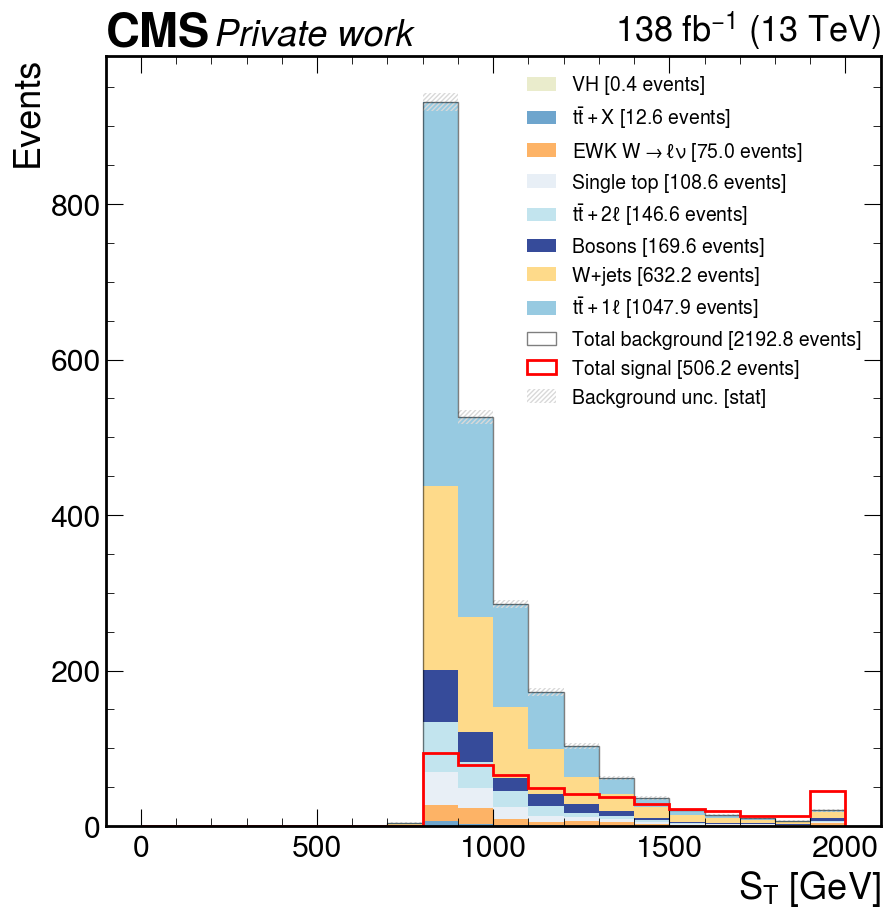

In [27]:
axes = vbswh.plot_sig_vs_bkg(
    "ST", np.linspace(0, 2000, 21), 
    selection="M_jj > 1500 and abs(deta_jj) > 5", x_label="$S_T$ [GeV]",
    stacked=True
);

In [28]:
vbswh.fom_scan(
    "ST", [1000, 1100, 1200, 1300, 1400, 1500, 1600, 1650, 1700, 1800], operator=">", 
    base_selection="M_jj > 1500 and abs(deta_jj) > 5"
)

sel,sig,bkg,fom
M_jj > 1500 and abs(deta_jj) > 5,506.16179925772275,2192.8279857666507,10.809038970625238
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1000,333.5153069708067,731.0477108893721,12.335106691887265
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1100,268.3300338435193,445.54342247065864,12.712303916912015
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1200,219.56385717747162,273.63387168267434,13.273208727475732
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300,178.1477174069907,170.51401147689083,13.642696768341922
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1400,140.16242819711746,109.05791075928339,13.421560886467665
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1500,111.75285096243022,73.04399766031415,13.07574204758558
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1600,90.09455923595651,52.22402917163642,12.467040700153527
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1650,80.05257051254964,44.568460025930506,11.991167450570744
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1700,70.544992255594,37.90091

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/aps/opt/hbbjet_score_sig_vs_bkg_stacked_norm.pdf


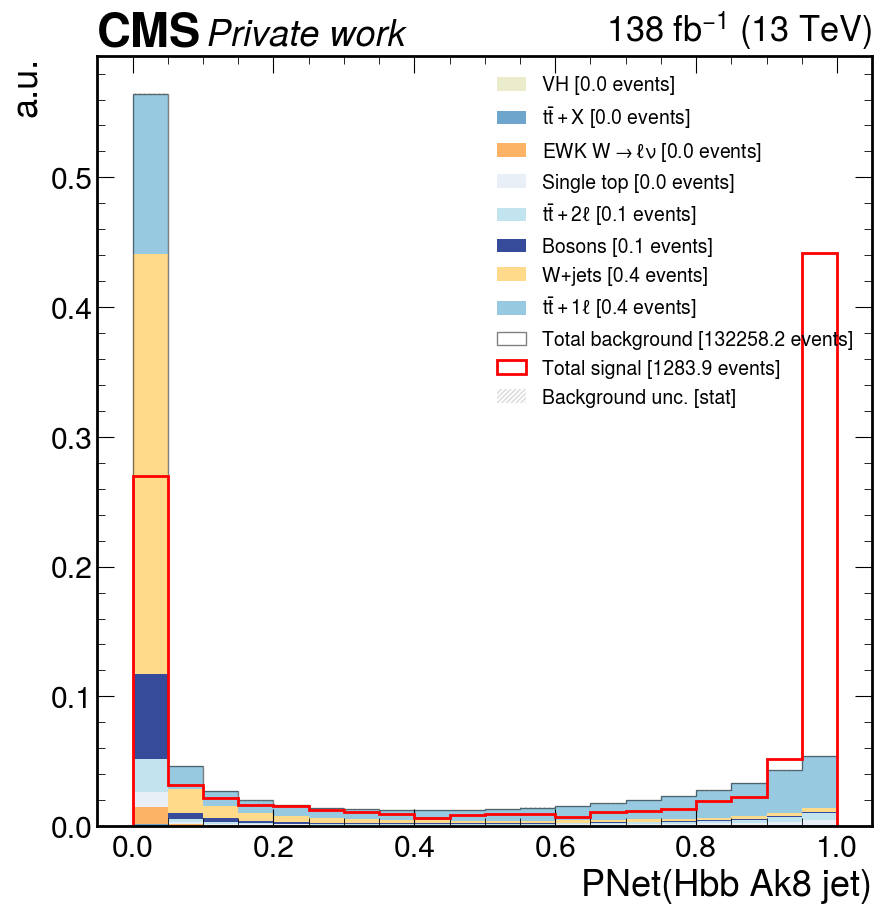

In [29]:
vbswh.plot_sig_vs_bkg(
    "hbbjet_score", np.linspace(0, 1.0, 21), 
#     selection="M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300", 
    x_label="PNet(Hbb Ak8 jet)",
    stacked=True,
    norm=True
);

In [ ]:
vbswh.fom_scan(
    "hbbjet_score", np.linspace(0.91, 0.99, 9), operator=">", 
    base_selection="M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300"
)

sel,sig,bkg,fom
